In [2]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

%pylab inline

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
train_path = glob.glob('./苹果病害图像识别挑战赛公开数据/train/*/*')
test_path = glob.glob('./苹果病害图像识别挑战赛公开数据/test/*')

np.random.shuffle(train_path)
np.random.shuffle(test_path)

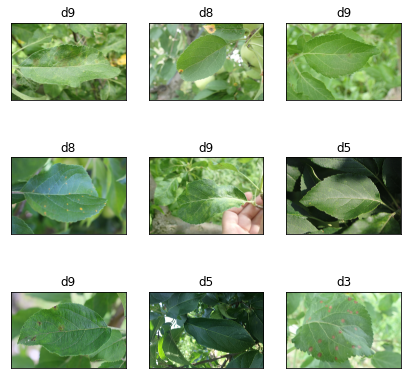

In [90]:
plt.figure(figsize=(7, 7))
for idx in range(9):
    plt.subplot(3, 3, idx+1)
    plt.imshow(Image.open(train_path[idx]))
    plt.xticks([]);
    plt.yticks([]);
    
    plt.title(train_path[idx].split('/')[-2])

In [91]:
len(train_path), len(test_path)

(10211, 4371)

In [60]:
DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        if self.img_path[index] in DATA_CACHE:
            img = DATA_CACHE[self.img_path[index]]
        else:
            img = cv2.imread(self.img_path[index])
            DATA_CACHE[self.img_path[index]] = img
        
        
        if self.transform is not None:
            img = self.transform(image = img)['image']
        
        if self.img_path[index].split('/')[-2] in ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9']:
            label = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'].index(self.img_path[index].split('/')[-2])
        else:
            label = -1
        
        img = img.transpose([2,0,1])
        return img, torch.from_numpy(np.array(label))
    
    def __len__(self):
        return len(self.img_path)

In [61]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
                
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512, 9)
        self.resnet = model
        
    def forward(self, img):        
        out = self.resnet(img)
        return out

In [76]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            print('Train loss', loss.item())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_acc = 0.0
    
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)
            
            val_acc += (output.argmax(1) == target).sum().item()
            
    return val_acc / len(val_loader.dataset)

def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    test_pred = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)

In [77]:
import albumentations as A

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-1000],
            A.Compose([
            A.RandomRotate90(),
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-1000:],
            A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=30, shuffle=False, num_workers=1, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
            A.Compose([
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

In [78]:
for data, lable in train_loader:
    break

In [79]:
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

/home/lyz/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/lyz/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
for _  in range(3):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc  = validate(val_loader, model, criterion)
    train_acc = validate(train_loader, model, criterion)
    
    print(train_loss, train_acc, val_acc)

Train loss 2.2545018196105957
Train loss 1.2741355895996094
Train loss 0.8521319627761841
Train loss 0.861651599407196
Train loss 0.49613693356513977
Train loss 0.29787498712539673
Train loss 1.0657925605773926
Train loss 0.325284868478775
Train loss 0.6994998455047607
Train loss 0.4378790557384491
Train loss 0.2327258586883545
Train loss 0.7312375903129578
Train loss 0.39839833974838257
Train loss 0.15284697711467743
Train loss 0.366984486579895
Train loss 0.30065733194351196
0.6105081921370773 0.8452936706112257 0.859
Train loss 0.3844166696071625
Train loss 0.5361185073852539
Train loss 0.2942914366722107
Train loss 0.21940727531909943
Train loss 0.32017746567726135
Train loss 0.5987720489501953
Train loss 0.7167405486106873
Train loss 0.24388320744037628
Train loss 0.14863447844982147
Train loss 0.3036178648471832
Train loss 0.2671392858028412
Train loss 0.22188915312290192
Train loss 0.36946868896484375
Train loss 0.09309697896242142
Train loss 0.46297964453697205
Train loss 0.327

In [81]:
pred = None

for _ in range(10):
    if pred is None:
        pred = predict(test_loader, model, criterion)
    else:
        pred += predict(test_loader, model, criterion)

In [83]:
submit = pd.DataFrame(
    {
        'uuid': [x.split('/')[-1] for x in test_path],
        'label': [['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'][x] for x in pred.argmax(1)]
})

In [84]:
submit = submit.sort_values(by='uuid')
submit.to_csv('submit2.csv', index=None)